In [1]:
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import xtrack as xt
import xcoll as xc
import xpart as xp
import xobjects as xo

In [ ]:
# Settings
plane = 'DPpos'
chroma = 0.5
nemitt = 2e-6
sigma_z = 0
delta = 0
num_particles  = 100

sim_name = f'gaussian_{plane}_nemitt{nemitt}_sigma_z{sigma_z}_delta{delta}_{num_particles}part'

In [3]:
#Line
line = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta2.json')

line.vars['qph_setvalue'] = chroma
line.vars['qpv_setvalue'] = chroma
line.vars['qh_setvalue'] = line.vars['qx0']._value + 0.05
line.vars['qv_setvalue'] = line.vars['qy0']._value + 0.05

cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)

for name in cavity_names:
    line[name].frequency = 200e6
    line[name].lag = 180
line['actcse.31632'].voltage = 3e6

Loading line from dict:   0%|          | 0/36395 [00:00<?, ?it/s]

Done loading line from dict.           


In [ ]:
context = xo.ContextCpu()

sweep = 6000
sweep = -abs(sweep) if plane == 'DPpos' else abs(sweep)
num_turns = 6000

In [5]:
#Installing TIDP
tidp_ap_tot = 147e-3
block_mvt = 29e-3

tidp = xc.EverestCollimator(length=4.3, material=xc.materials.Carbon, jaw_L= tidp_ap_tot/2 + block_mvt, jaw_R = -tidp_ap_tot/2 + block_mvt)
line.collimators.install(names=['tidp.11434'], elements=[tidp])

Slicing line:   0%|          | 0/75252 [00:00<?, ?it/s]

In [6]:
bpms_hor = ['bph.10208',
 'bph.10408',
 'bph.10608',
 'bph.10808',
 'bph.11008',
 'bph.11208',
 'bph.11408',
 'bph.11608',
 'bph.11831',
 'bph.12008',
 'bph.12208',
 'bph.12408',
 'bph.12608',
 'bph.12808',
 'bph.13008',
 'bph.13208',
 'bph.13408',
 'bph.13608',
 'bph.20208',
 'bph.20408',
 'bph.20608',
 'bph.20808',
 'bph.21008',
 'bph.21208',
 'bph.21408',
 'bpce.21604',
 'bpce.21706',
 'bpce.21803',
 'bph.22008',
 'bph.22208',
 'bph.22408',
 'bph.22608',
 'bph.22808',
 'bph.23008',
 'bph.23208',
 'bph.23408',
 'bph.23608',
 'bph.30208',
 'bph.30408',
 'bph.30608',
 'bph.30808',
 'bph.31008',
 'bph.31208',
 'bph.31408',
 'bph.31608',
 'bph.31808',
 'bph.32008',
 'bph.32208',
 'bph.32408',
 'bph.32608',
 'bph.32808',
 'bph.33008',
 'bph.33208',
 'bph.33408',
 'bph.33608',
 'bph.40208',
 'bph.40408',
 'bph.40608',
 'bph.40808',
 'bph.41008',
 'bph.41208',
 'bph.41408',
 'bpce.41705',
 'bpce.41801',
 'bpce.41931',
 'bph.42008',
 'bph.42208',
 'bph.42408',
 'bph.42608',
 'bph.42808',
 'bph.43008',
 'bph.43208',
 'bph.43408',
 'bph.43608',
 'bph.50208',
 'bph.50408',
 'bph.50608',
 'bph.50808',
 'bph.51008',
 'bph.51208',
 'bph.51408',
 'bpce.51604',
 'bpce.51833',
 'bph.52008',
 'bph.52208',
 'bph.52408',
 'bph.52608',
 'bph.52808',
 'bph.53008',
 'bph.53208',
 'bph.53408',
 'bph.53608',
 'bph.60208',
 'bph.60408',
 'bph.60608',
 'bph.60808',
 'bph.61008',
 'bph.61208',
 'bph.61408',
 'bph.61608',
 'bpce.61705',
 'bpce.61804',
 'bpce.61931',
 'bph.62008',
 'bph.62208',
 'bph.62408',
 'bph.62608',
 'bph.62808',
 'bph.63008',
 'bph.63208',
 'bph.63408',
 'bph.63608']

In [7]:
monitors = []
for bpm in bpms_hor:
    if bpm in line.element_names:
        monitors.append(xc.EmittanceMonitor.install(line, f'{bpm}_monitor', at_s=line.get_s_position(bpm), 
                                                    stop_at_turn=num_turns, num_particles=num_particles, monitor_delta=True))
    else:
        monitors.append(xc.EmittanceMonitor.install(line, f'{bpm}_monitor', at_s=line.get_s_position(f'{bpm}..0'), 
                                                    stop_at_turn=num_turns, num_particles=num_particles, monitor_delta=True))

In [8]:
tw = line.twiss()
tt = line.get_table()

In [9]:
line.build_tracker()
part = xp.generate_matched_gaussian_bunch(nemitt_x=nemitt, nemitt_y=nemitt,
                                          sigma_z=sigma_z, num_particles=num_particles, line=line) #sigma_z=0.224
part.delta = 0

The line already has an associated tracker


In [10]:
rf_sweep = xc.RFSweep(line)
rf_sweep.info(sweep=sweep, num_turns=num_turns)

line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu(omp_num_threads='25'))
line.scattering.enable()
rf_sweep.track(sweep=sweep, particles=part, num_turns=num_turns, time=True, with_progress=5)
line.scattering.disable()

The current frequency is 200000000.0Hz, adding -1.0Hz per turn until 199994000.0 (for 6000 turns).
This sweep will move the center of the bucket with Δδ = 0.01689694767914598 (2.664416947059372 buckets).
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

All particles lost at turn 3734, stopped sweep at -2988.0Hz.


In [11]:
np.unique(part.state, return_counts=True)

(array([0]), array([100]))

In [12]:
x = []
x2 = []
delta = []
y = []
y2 = []
delta_calc = []
for monitor in monitors:
    x.append(monitor.x_mean)
    x2.append(monitor.x_x_var)
    y.append(monitor.y_mean)
    y2.append(monitor.y_y_var)
    delta.append(monitor.delta_mean)
    delta_calc.append((monitor.x_mean - tw.rows[monitor.name].x)/tw.rows[monitor.name].dx)

/home/lpauwels/Xsuite/xcoll/xcoll/beam_elements/monitor.py:450: RuntimeWarning: invalid value encountered in sqrt
  gemitt_x = np.sqrt(self.x_x_var * self.px_px_var - self.x_px_var**2)
/home/lpauwels/Xsuite/xcoll/xcoll/beam_elements/monitor.py:451: RuntimeWarning: invalid value encountered in sqrt
  gemitt_y = np.sqrt(self.y_y_var * self.py_py_var - self.y_py_var**2)
/home/lpauwels/Xsuite/xcoll/xcoll/beam_elements/monitor.py:452: RuntimeWarning: invalid value encountered in sqrt
  gemitt_zeta = np.sqrt(self.zeta_zeta_var * self.pzeta_pzeta_var - self.zeta_pzeta_var**2)


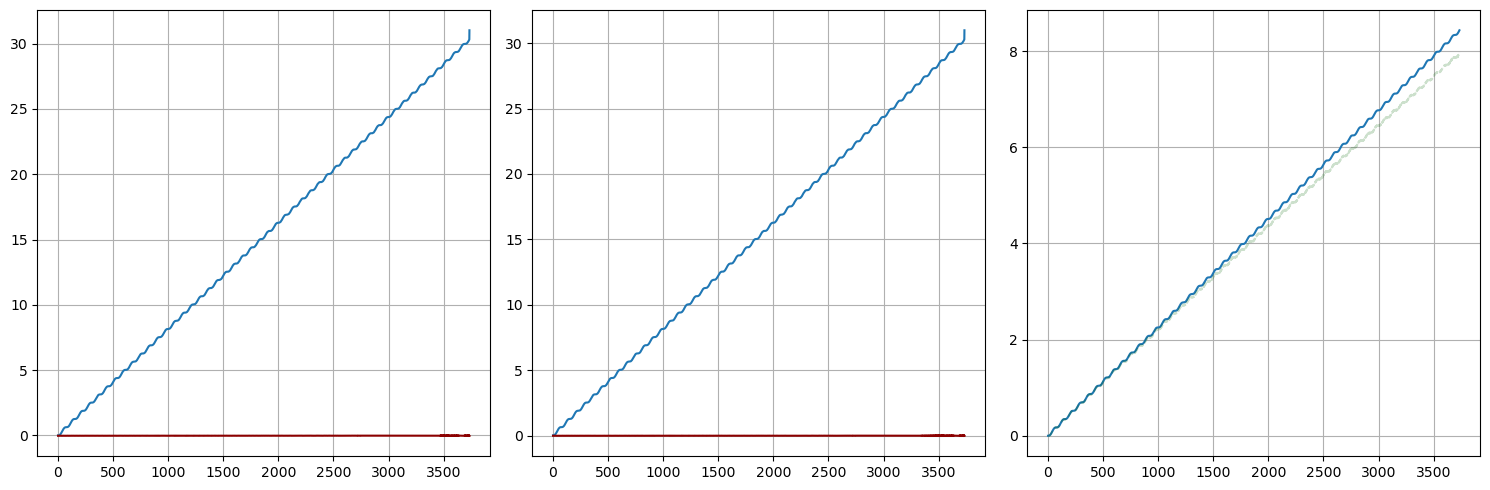

In [13]:
turns_of_death = sorted(part.at_turn)
index_cut = int(0.9 * len(turns_of_death))
turn_cut = 6000#turns_of_death[index_cut]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(ak.mean(x, axis=0)[:turn_cut]*1e3, label='x')
ax[0].plot(ak.mean(y, axis=0)[:turn_cut]*1e3, label='y', color='darkred')
ax[1].plot(ak.mean(x2 + ak.Array(x)*999/1000, axis=0)[:turn_cut]*1e3, label='x2')
ax[1].plot(ak.mean(y2+ ak.Array(y)*999/1000, axis=0)[:turn_cut]*1e3, label='y2', color='darkred')
ax[2].plot(ak.mean(delta, axis=0)[:turn_cut]*1e3, label='delta')
ax[2].plot(ak.mean(delta_calc, axis=0)[:turn_cut]*1e3, label='delta_calc', color='darkgreen', ls = '--', alpha=0.2)
for axis in ax:
    axis.grid()
fig.tight_layout()
plt.savefig(f'{sim_name}.png', dpi=300)